<a href="https://colab.research.google.com/github/nasrinsaalehi/Drawning-Detection-/blob/main/03_My_PyTorch_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch computer vision
* see the reference notebook
* see reference online bookmm


# Computer vision libraries in PyTorch
* [`torchvision`]
* `torchvision.datasets` - Get datasets and dataloading functions for computer vision
* `torchvision.models` - Get pretrained computer vision models that you can leverge for your own problems
* `torchvision.transforms` - Functions for manupulating images suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for Pytorch
* `torchutils.data.Dataloader` - Creates a python iterable over a dataset

In [123]:
# import PyTorch
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib for visuslization
import matplotlib.pyplot as plt

# check versions
print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


## 1. Getting a dataset
The dataset we are going to work with is FasionMNIST from `torchvison.datasets`

In [124]:
# set up train data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root= "data", # where to download the dataset
    train= True, # do we want the training dataset/test
    download= True, # do we want to download yes/no
    transform= torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform= None # how do we want to transform the targets
)
test_data= datasets.FashionMNIST(
    root= "data",
    train= False,
    download= True,
    transform= ToTensor(),
    target_transform= None
)

In [125]:
len(train_data), len(test_data)

(60000, 10000)

In [126]:
# see the first training example
# each item in train_data is a touple containing image and a label
image, label= train_data[0]

In [127]:
label

9

In [128]:
train_data[0][1] # another way to get the label of the image wich is a part of a touple in python

9

In [129]:
class_names= train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [130]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [131]:
print(f"Image shape like NCHW with is for pytorch {image.shape}")
print(f"class name for the first iamge of the tain data: {class_names[label]}")


Image shape like NCHW with is for pytorch torch.Size([1, 28, 28])
class name for the first iamge of the tain data: Ankle boot


In [132]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

## 1.2 Visualizing our data

image shape: torch.Size([1, 28, 28])


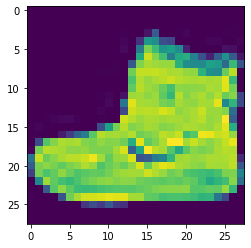

In [133]:
import matplotlib.pyplot as plt
image, label= train_data[0]
print(f"image shape: {image.shape}")
#plt.imshow(image[0,:,:])
plt.imshow(image.squeeze())

(-0.5, 27.5, 27.5, -0.5)

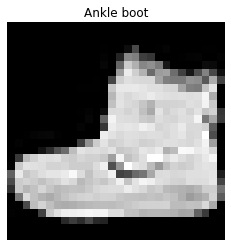

In [134]:
plt.imshow(image.squeeze(),cmap= "gray")
plt.title(class_names[label])
plt.axis(False)

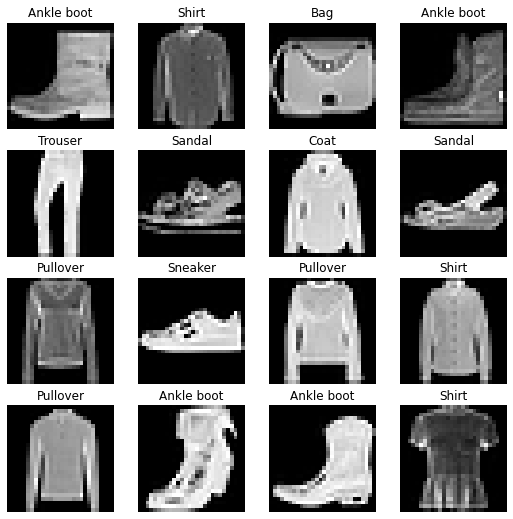

In [135]:
# plot some random images
torch.manual_seed(42)
fig= plt.figure(figsize= (9,9))
rows, cols = 4, 4
for i in range (1, rows*cols+1):
  random_idx= torch.randint(0, len(train_data), size=[1]).item()
  img, label= train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)



## 2. Prepare DataLoader
right now our data is in the form of Pytorxh datasets
DataLoader turns our dataset into a Python iterable.
more specifically, we want to turn our data to **mini-batches**.
why would we do this?
1. It is more computationally efficient as in your computing hardware may not be able to look (srore in memory) at 60000 images in one hit. so we break it down to 32 images at a time (batch size of 32)
2. It gives our neural network more chances to pdate its gradients per epoch.


In [136]:
from torch.utils.data import DataLoader
# set up the batch size hyper- parameter
BATCH_SIZE= 32

# turn dataset to iterables (batches)
train_dataloader= DataLoader(dataset= train_data,
                             batch_size= BATCH_SIZE,
                             shuffle= True)
test_dataloader= DataLoader(dataset= test_data,
                            batch_size= BATCH_SIZE,
                            shuffle= False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fbe24fbe6d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fbe24fbe250>)

In [137]:
# lets check out what we have created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the train DataLoader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of the test DataLoader: {len(test_dataloader)} batches of {BATCH_SIZE}")


DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fbe24fbe6d0>, <torch.utils.data.dataloader.DataLoader object at 0x7fbe24fbe250>)
Length of the train DataLoader: 1875 batches of 32...
Length of the test DataLoader: 313 batches of 32


In [138]:
# Check out whats inside the trianig dataloader
# dataloaders contain image and label batches of type **tensor**
train_features_batch, train_labeles_batch= next(iter(train_dataloader))
train_features_batch.shape, train_labeles_batch.shape


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

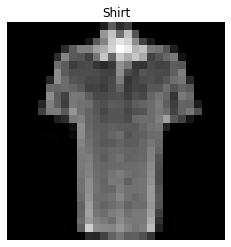

In [139]:
# show a sample
torch.manual_seed(42)
random_idx= torch.randint(0, len(train_features_batch), size= [1]).item()
img, label= train_features_batch[random_idx], train_labeles_batch[random_idx]
plt.imshow(img.squeeze(), cmap= "gray")
plt.title(class_names[label])
plt.axis(False)


## 3.1 Model 0 : Build a Baseline model
when starting to build a series of machine learning experiments, its best to practice to start with a baseline model.
A baseline model is a simple model you will try and improve upon with subsequent modelsexperiments.train_labeles_batchin other words, start simply and add complexity when nexessary.


In [140]:
# Create a flatten layer
flatten_model= nn.Flatten()

# Get a single sample
x= train_features_batch[0]

# Flatten the sample
output= flatten_model(x)

# print out what happened
print(f"shape before flattening: {x.shape}")
print(f"shape after flattening: {output.shape}")

shape before flattening: torch.Size([1, 28, 28])
shape after flattening: torch.Size([1, 784])


In [141]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_shape: int,
               output_shape: int):
    super().__init__()
    self.layer_stack= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features= hidden_shape),
        nn.Linear(in_features= hidden_shape, out_features= output_shape)
    )
  def forward(self, x: torch.Tensor)->torch.Tensor:
    return self.layer_stack(x)


In [142]:
torch.manual_seed(42)

# set up model wth input parameters
model_0= FashionMNISTModelV0(input_shape= 28*28,
                             hidden_shape= 10,
                             output_shape= len(class_names)
                             ).to("cpu")
#model_0.state_dict()

### 3.1 set up loss function, optimizer and evalution metrixs
* losss function- since we are working with multi-class data, our loss function woll be `nn.CrossEntropyloss()`
* Optimizer - our optimizer 'torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we are working on a classification problem  lets use accuracy as our evaluation metric


In [143]:
import requests 
from pathlib import Path

#downlaod helper functions frim learn pytorch repo
if Path("helper_functions.py").is_file():
  print("the file exists!")
else:
  print("Downloading helper_functions.py")
  request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/46a8b2988295e135e39d3320b4dcf95fe2ef3927/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


the file exists!


In [144]:
# import accuracy metric from helperfuncions
from helper_functions import accuracy_fn
# setup loss function and optimizer

loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(params= model_0.parameters(),
                           lr= 0.1)


### 3.2 Creating a function to time our experiments
Machine learning is very experimental
two of the main things you will often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [145]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device= None):
  total_time = end- start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time 


In [146]:
start_time = timer()
# some code ...
end_time= timer()
print_train_time(start= start_time, end= end_time, device= "cpu")

Train time on cpu: 0.000 seconds


4.49780000053579e-05

### 3.3 Creating a training loop and training model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print what is happening.
5. Time it all (for fun)

In [147]:

# import tqdm for progress bar
from tqdm.auto import tqdm

#Set the seed and star the timer

torch.manual_seed(42)
train_time_start_on_cpu= timer()

# set the number of the epochs
epochs= 3
# Create trining and test loop

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n -------")
  ### Trining 
  train_loss= 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. forward pass
    y_pred= model_0(X)

    #2. Calculate the loss
    loss= loss_fn(y_pred, y)
    train_loss+= loss # accumulate the train loss for each batch

    # 3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backward
    loss.backward()

    # 5. optimizer.step()
    optimizer.step()

    # print out what is happennig
    if batch % 400 == 0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")
  # Divide totao train loss bu length of the train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc= 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      #1. Forward pass
      test_pred= model_0(X_test)
      # 2. Calculate the loss
      test_loss+= loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc+= accuracy_fn(y_true=y_test, y_pred= test_pred.argmax(dim=1))
    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test accuracy average per batch
    test_acc /= len(test_dataloader)
  # Print out what is happenning
  print(f"\n Train Loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
# Calculate the training time
train_time_end_cpu= timer()
totao_train_time_model_0= print_train_time(start= train_time_start_on_cpu,
                                           end= train_time_end_cpu,
                                           device= str(next(model_0.parameters()).device)) 


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 -------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train Loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
 -------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train Loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
 -------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train Loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 20.994 seconds


In [148]:
## 4. Make prediction and get model 0 results
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc= 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      #make predictions
      y_pred = model(X)

      # Accumulate the acc and loss per batch
      loss+= loss_fn(y_pred, y)
      acc+= accuracy_fn(y_true= y,
                        y_pred= y_pred.argmax(dim=1))
      #Scale loss and acc to find the average lossacc per batch
    loss/= len(data_loader)
    acc/= len(data_loader)

      # return a dictionary
  return {"model_name": model.__class__.__name__,  # this only works when model is created by a class
          "model_loss": loss.item(),
          "model_acc": acc}

model_0_results= eval_model(model_0,
                            data_loader= test_dataloader,
                            loss_fn= loss_fn,
                            accuracy_fn= accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 6. Model 1: building a model with non-linearity
we did learn the power of non- linearity in the previos practice 02  part


### 6.2 Functionizing training and test loops
So far we've been writing train and test loops over and over.

Let's write them again but this time we'll put them in functions so they can be called again and again.

In [149]:
# set up device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"

In [172]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device= device):
  train_loss, train_acc=0, 0
  for epoch, (X, y) in enumerate(data_loader):

    # send data to device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred= model(X)

    # calculate the loss]
    loss = loss_fn(y_pred, y)
    train_loss +=train_loss
    train_acc += accuracy_fn(y_true= y,
                             y_pred= y_pred.argmax(dim=1))
    
    # oprimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

  # calculate loss and accuracy per epoch and print whats happening
  train_loss /= len(data_loader)
  train_acc/= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device= device):
  
  test_loss, test_acc= 0, 0 
  model.eval()
  with torch.inference_mode():
    for (X, y) in data_loader:
      # send data to device
      X, y= X.to(device), y.to(device)

      # forward pass
      y_pred= model(X)

      # calculate the loss and acc
      loss= loss_fn(y_pred, y)
      test_loss+= loss
      test_acc += accuracy_fn(y_true= y,
                               y_pred= y_pred.argmax(dim=1))
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

## Model 2 : Building a Convolutional Neural Network
CNNs are also known as ConvNets
CNNs are known for their capabilities to find patterns in visual data


In [151]:
# Create a Convolutional neural network
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    
    self.conv_block_1= nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2)
        )

    self.conv_block_2= nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2)         
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units*7*7,
                  out_features= output_shape)
    )
  def forward (self, x: torch.Tensor):
    x= self.conv_block_1(x)
    #print(f"input to the first conv block: {x.shape}")
    x= self.conv_block_2(x)
    #print(f"after the second conv block: {x.shape}")
    x= self.classifier(x)
    #print(f"after the classifier block: {x.shape}")
    return x



In [152]:
torch.manual_seed(42)
model_2= FashionMNISTModelV2(input_shape= 1, # 3 if we had 3 channels
                             hidden_units= 10,
                             output_shape= len(class_names)).to(device)

### 7.1 Stepping through `nn.Conv2d()`
see the torch documentation for the formula.

In [153]:
torch.manual_seed(42)
# create a batch of images
images = torch.randn(size= (32, 3, 64, 64))
test_image = images[0]

print(f"image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image : \n{test_image}")

image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image : 
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-

In [154]:
# create a single conv2d layer
conv_layer= nn.Conv2d(in_channels= 3,
                     out_channels= 10,
                     kernel_size= 3,
                     stride= 1,
                     padding= 0)
# pass the data through the convolutional layer
conv_output= conv_layer(test_image.unsqueeze(dim=0))
conv_output.shape

torch.Size([1, 10, 62, 62])

### 7.2 Stepping through `nn.MaxPool2d()`

In [155]:
test_image.shape

torch.Size([3, 64, 64])

In [156]:
# print the original image shape without unsqueeze dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image shape with unsqueezed dimensios: {test_image.unsqueeze(dim=0).shape}")

# pass image through the maxpool layer
test_image_through_conv= conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

#pass data throgh the max pool layer
max_pool_layer= nn.MaxPool2d(kernel_size= 2)
test_image_through_maxpool= max_pool_layer(test_image_through_conv)
print(f"Shape after going through maxpool_layer(): {test_image_through_maxpool.shape}")


Test image original shape: torch.Size([3, 64, 64])
Test image shape with unsqueezed dimensios: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through maxpool_layer(): torch.Size([1, 10, 31, 31])


In [157]:
# pass a random image through the model to see the dimension of input layer of classifier layer
rand_image= torch.randn(size= (1, 1, 28, 28))
model_2= FashionMNISTModelV2(input_shape= 1,
                             hidden_units= 10,
                             output_shape= len(class_names)).to(device)
output_image= model_2(rand_image.to(device))          

## 7.3 Set up a loss function and optimizer for model 2

In [162]:
from helper_functions import accuracy_fn
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model_2.parameters(),
                           lr= 0.1)
#model_2.state_dict()

### 7.4 Training and testing our model 2 using the functions


In [173]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from timeit import default_timer as default_timer
train_time_start_model_2= timer()

epochs= 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")
  train_step(model= model_2, 
             data_loader= train_dataloader,
             loss_fn= loss_fn,
             optimizer= optimizer,
             accuracy_fn= accuracy_fn,
             device= device)
  test_step(model= model_2,
            data_loader= test_dataloader,
            loss_fn= loss_fn,
            accuracy_fn= accuracy_fn)
train_time_end_model_2= timer()
total_train_time_model_2= print_train_time(train_time_start_model_2,
                                             train_time_end_model_2,
                                             device= device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.00000 | Train accuracy: 77.83%
Test loss: 0.38097 | Test accuracy: 86.57%

Epoch: 1
--------
Train loss: 0.00000 | Train accuracy: 87.48%
Test loss: 0.34537 | Test accuracy: 87.77%

Epoch: 2
--------
Train loss: 0.00000 | Train accuracy: 88.80%
Test loss: 0.32183 | Test accuracy: 88.33%

Train time on cpu: 140.158 seconds


In [174]:
 # Get model_2 results
 model_2_results= eval_model(model= model_2,
                             data_loader= test_dataloader,
                             loss_fn= loss_fn,
                             accuracy_fn= accuracy_fn)
 model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32182949781417847,
 'model_acc': 88.32867412140575}

In [175]:
# compare the results
import pandas as pd 
compare_results= pd.DataFrame([model_0_results,
                               model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV2,0.321829,88.328674


Text(0, 0.5, 'Model Accuracy')

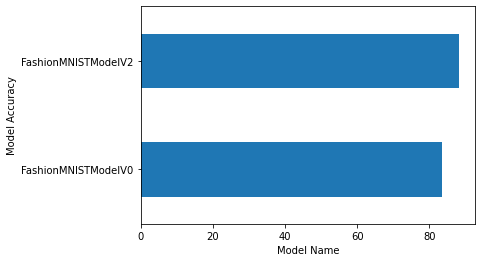

In [177]:
compare_results.set_index("model_name")["model_acc"].plot(kind= "barh")
plt.xlabel("Model Name")
plt.ylabel("Model Accuracy")

# 10. Making a Confusion Matrix
A confusion matrix is a fantatic way of evaluating your model on the test dataset
1. make predictions woth our trained model on the test dataset.
2. make a confusion matrix `torchmetrics.ConfusionMatrix`
3. plot the confusion matrix using `mlxtend.ploting.plot_confusion_matrix()`


In [204]:
from tqdm.auto import tqdm

# make predictions
y_preds= []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm((test_dataloader), desc= "Making predictions ..."):
    X, y= X.to(device), y.to(device)
    y_logit= model_2(X) 
    y_pred= torch.softmax(y_logit,dim=1).argmax(dim= 1) 
    y_preds.append(y_pred.cpu())
y_pred_tensor= torch.cat(y_preds)
y_pred_tensor[:10]  

Making predictions ...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [200]:
len(y_pred_tensor)

10000

In [203]:
import mlxtend
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.3 MB/s 


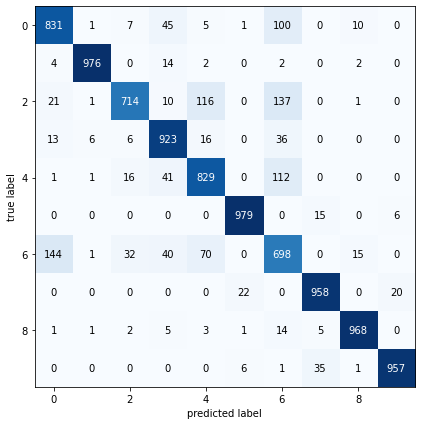

In [214]:
#make the confuson matrix  
confmat= ConfusionMatrix(num_classes= len(class_names),task ="multiclass")
confmat_tensor= confmat(preds= y_pred_tensor,
                       target = test_data.targets)

# plot the conf matrix
fig, ax= plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    figsize= (10, 7)
)

In [219]:
## 11. Save and load a model
from pathlib import Path
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok= True)
MODEL_NAME= "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH= MODEL_PATH/ MODEL_NAME

print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj= model_2.state_dict(),
           f= MODEL_SAVE_PATH)

saving model to: models/03_pytorch_computer_vision_model_2.pth
